In [1]:
import os
# Deshabilitar completamente el acceso a GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Deshabilitar logs innecesarios de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (InputLayer, Conv2D, BatchNormalization, 
                                     MaxPool2D, Dropout, Flatten, Dense)
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# ==============================================
# ==============================================
# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

# Pillow
from PIL import Image

E0000 00:00:1748536582.067823 3784429 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748536582.071116 3784429 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Cargar datos
X_train = np.load('../Datasets_DeepShadows/array_images/X_train.npy')
y_train = np.load('../Datasets_DeepShadows/Galaxies_data/y_train.npy')
X_val = np.load('../Datasets_DeepShadows/array_images/X_val.npy')
y_val = np.load('../Datasets_DeepShadows/Galaxies_data/y_val.npy')
X_test = np.load('../Datasets_DeepShadows/array_images/X_test.npy')
y_test = np.load('../Datasets_DeepShadows/Galaxies_data/y_test.npy')

In [4]:
print(f"Forma de los datos - Entrenamiento: {X_train.shape}, Validación: {X_val.shape}, Test: {X_test.shape}")

Forma de los datos - Entrenamiento: (29580, 64, 64, 3), Validación: (4990, 64, 64, 3), Test: (4983, 64, 64, 3)



#### Plot examples of LSBGs and Artifacts

Now let's make a plot of a random sample of 20 LSBGs and 20 artefacts from the training set.


In [5]:
X_pos = X_train[y_train==1.] #Positives - LSBGs
X_neg = X_train[y_train==0.] #Negatives - Artifacts
# Get some random indices
randind = np.random.randint(0,15000,20)
print(randind)
randind  = [9221,10239,1601,1590,9178,1388,4419,3591,11241,12395,3422,441,
            11547,7808,11841,12008,5189,1081,6403,6299]

X_sample_LSBG = X_pos[randind]
X_sample_Artefacts = X_neg[randind]

[ 9393  5904  8988 13411  2054  3399 13503  5536   448 14564  6046  9484
   350  9892  1428 12737  6930 12994  2573  2441]


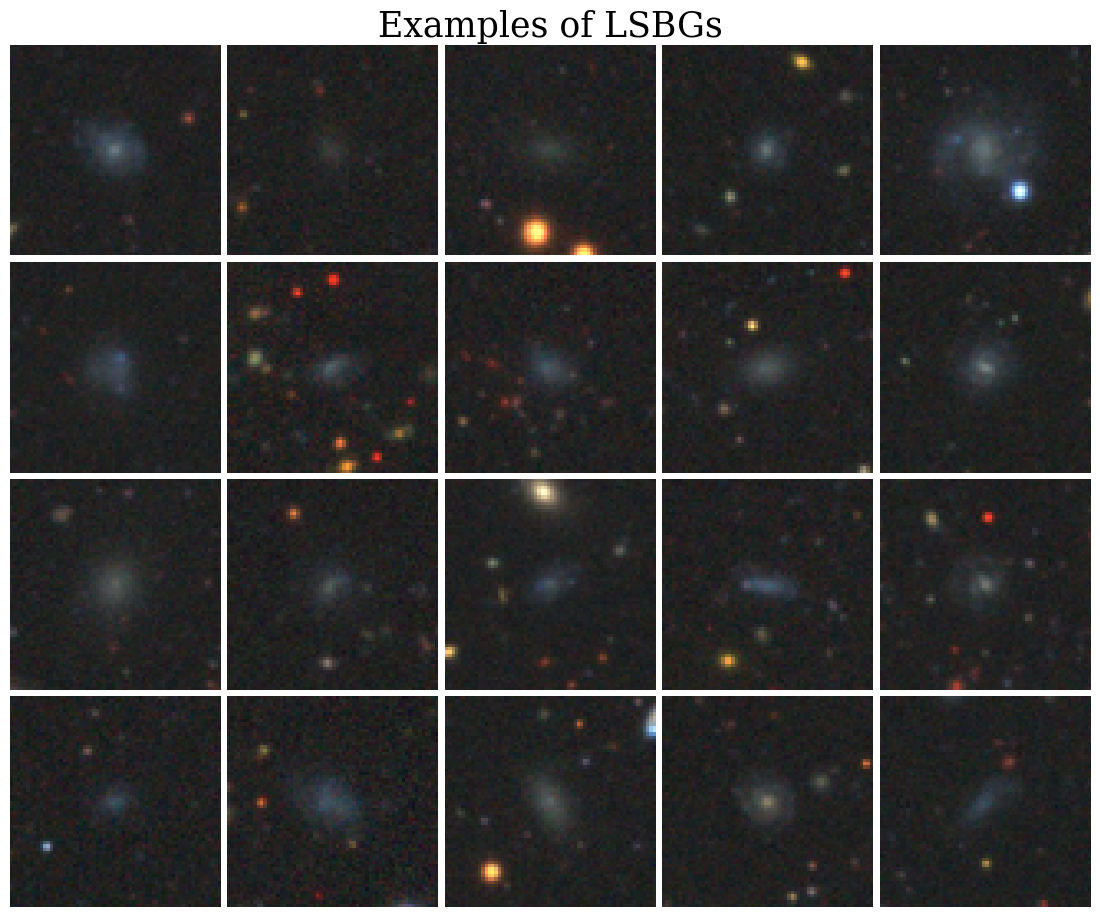

In [6]:
# Plot them
n_rows = 4
n_cols = 5

plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Examples of LSBGs",fontsize=25)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_sample_LSBG[i])
    plt.axis('off')


plt.subplots_adjust(wspace=0.01, hspace=0.03)
#plt.tight_layout()
# plt.savefig("/content/drive/My Drive/Plots/LSBG_Examples.pdf")
#files.download("/content/drive/My Drive/Plots/LSBG_Examples.pdf")
plt.show()

Plot examples of artefacts

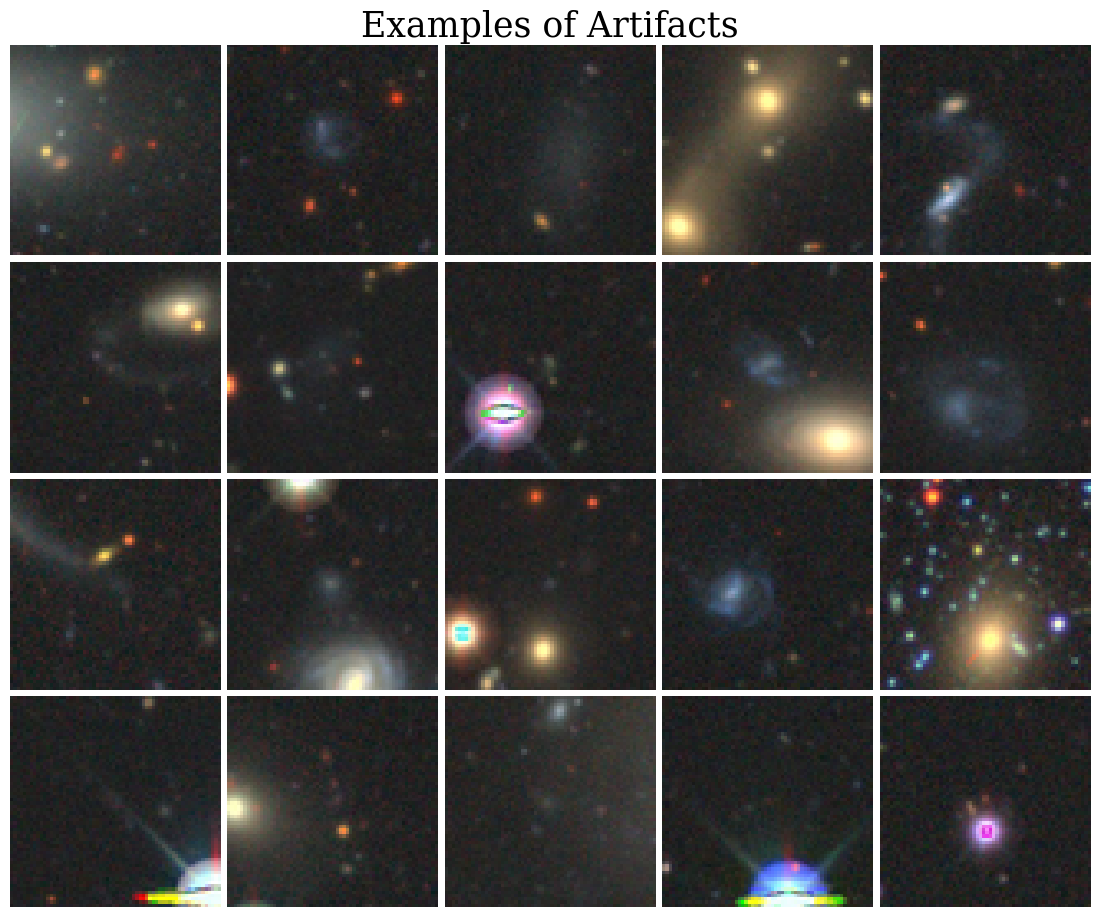

In [7]:
plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Examples of Artifacts",fontsize=25)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_sample_Artefacts[i])
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)
#plt.tight_layout()
#plt.savefig("/content/drive/My Drive/Plots/Artifacts_Examples.pdf")
#files.download("/content/drive/My Drive/Plots/Artifacts_Examples.pdf")
plt.show()

## Deep Learning

Here we use the DL architecture to classify galaxies, using directly the astronomical images data downladed from Legacy survey.

In [8]:
# Construir el modelo exacto del paper
model = Sequential([
    InputLayer(input_shape=(64, 64, 3)),  # Capa de entrada explícita
    
    # Bloque 1
    Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu',
           kernel_regularizer=regularizers.l2(0.13)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.4),
    
    # Bloque 2
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu',
           kernel_regularizer=regularizers.l2(0.13)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.4),
    
    # Bloque 3
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu',
           kernel_regularizer=regularizers.l2(0.13)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.4),
    
    # Capas fully connected
    Flatten(),
    Dense(units=1024, activation='relu', 
          kernel_regularizer=regularizers.l2(0.12)),
    Dense(units=1, activation='sigmoid')
])

# Compilar con los parámetros del paper
model.compile(optimizer=optimizers.Adadelta(learning_rate=0.1),
              loss='binary_crossentropy',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

model.summary()

/home/luisangel/.conda/envs/luis_env_v2/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,220,385 (16.10 MB)

 Trainable params: 4,220,161 (16.10 MB)

 Non-trainable params: 224 (896.00 B)

In [9]:
# Callbacks para entrenamiento eficiente en CPU
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

In [10]:
# Entrenamiento
print("\nComenzando entrenamiento en CPU...")
history = model.fit(
    x=X_train, y=y_train,
    epochs=50,  # Más épocas pero con early stopping
    batch_size=32,  # Batch size más pequeño para CPU
    shuffle=True,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)


Comenzando entrenamiento en CPU...
Epoch 1/50
925/925 ━━━━━━━━━━━━━━━━━━━━ 107s 114ms/step - accuracy: 0.7990 - loss: 79.5280 - precision: 0.7877 - recall: 0.8395 - val_accuracy: 0.8621 - val_loss: 1.9881 - val_precision: 0.8192 - val_recall: 0.9480 - learning_rate: 0.1000
Epoch 2/50
925/925 ━━━━━━━━━━━━━━━━━━━━ 104s 113ms/step - accuracy: 0.8903 - loss: 1.2578 - precision: 0.8747 - recall: 0.9232 - val_accuracy: 0.9046 - val_loss: 0.5677 - val_precision: 0.8749 - val_recall: 0.9560 - learning_rate: 0.1000
Epoch 3/50
925/925 ━━━━━━━━━━━━━━━━━━━━ 106s 115ms/step - accuracy: 0.9094 - loss: 0.4809 - precision: 0.8942 - recall: 0.9370 - val_accuracy: 0.9002 - val_loss: 0.4254 - val_precision: 0.8586 - val_recall: 0.9708 - learning_rate: 0.1000
Epoch 4/50
925/925 ━━━━━━━━━━━━━━━━━━━━ 102s 110ms/step - accuracy: 0.9139 - loss: 0.3704 - precision: 0.8982 - recall: 0.9400 - val_accuracy: 0.9010 - val_loss: 0.3795 - val_precision: 0.8520 - val_recall: 0.9833 - learning_rate: 0.1000
Epoch 5/50


Epoch 31/50
925/925 ━━━━━━━━━━━━━━━━━━━━ 108s 117ms/step - accuracy: 0.9339 - loss: 0.2204 - precision: 0.9220 - recall: 0.9537 - val_accuracy: 0.9299 - val_loss: 0.2251 - val_precision: 0.9084 - val_recall: 0.9643 - learning_rate: 0.0500
Epoch 32/50
925/925 ━━━━━━━━━━━━━━━━━━━━ 107s 116ms/step - accuracy: 0.9288 - loss: 0.2297 - precision: 0.9153 - recall: 0.9509 - val_accuracy: 0.9251 - val_loss: 0.2354 - val_precision: 0.9280 - val_recall: 0.9301 - learning_rate: 0.0500
Epoch 33/50
925/925 ━━━━━━━━━━━━━━━━━━━━ 105s 113ms/step - accuracy: 0.9307 - loss: 0.2247 - precision: 0.9190 - recall: 0.9496 - val_accuracy: 0.9180 - val_loss: 0.2450 - val_precision: 0.9337 - val_recall: 0.9093 - learning_rate: 0.0500
Epoch 34/50
925/925 ━━━━━━━━━━━━━━━━━━━━ 106s 114ms/step - accuracy: 0.9302 - loss: 0.2220 - precision: 0.9175 - recall: 0.9503 - val_accuracy: 0.9311 - val_loss: 0.2228 - val_precision: 0.9344 - val_recall: 0.9351 - learning_rate: 0.0500
Epoch 35/50
925/925 ━━━━━━━━━━━━━━━━━━━━ 108

In [14]:
# Evaluación final
print("\nEvaluando modelo...")
results = model.evaluate(X_test, y_test, verbose=0)

# Extraer resultados
test_loss = results[0]
test_acc = results[1]
test_precision = results[2]
test_recall = results[3]

# Calcular F1-score
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall + 1e-7)

print(f"\nResultados finales en test set:")
print(f" - Pérdida: {test_loss:.4f}")
print(f" - Precisión (accuracy): {test_acc:.4f}")
print(f" - Precision: {test_precision:.4f}")
print(f" - Recall: {test_recall:.4f}")
print(f" - F1-score: {test_f1:.4f}")


Evaluando modelo...

Resultados finales en test set:
 - Pérdida: 0.1936
 - Precisión (accuracy): 0.9366
 - Precision: 0.9146
 - Recall: 0.9727
 - F1-score: 0.9428


Mas robusta version

In [15]:
# Evaluación final
print("\nEvaluando modelo...")
results = model.evaluate(X_test, y_test, verbose=0)

# Obtener nombres de métricas
metrics_names = model.metrics_names  # ['loss', 'accuracy', 'precision', 'recall']

print("\nResultados finales en test set:")
for name, value in zip(metrics_names, results):
    print(f" - {name}: {value:.4f}")

# Si tenemos precision y recall, calcular F1
if 'precision' in metrics_names and 'recall' in metrics_names:
    precision_idx = metrics_names.index('precision')
    recall_idx = metrics_names.index('recall')
    precision = results[precision_idx]
    recall = results[recall_idx]
    f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
    print(f" - F1-score: {f1:.4f}")


Evaluando modelo...

Resultados finales en test set:
 - loss: 0.1936
 - compile_metrics: 0.9366


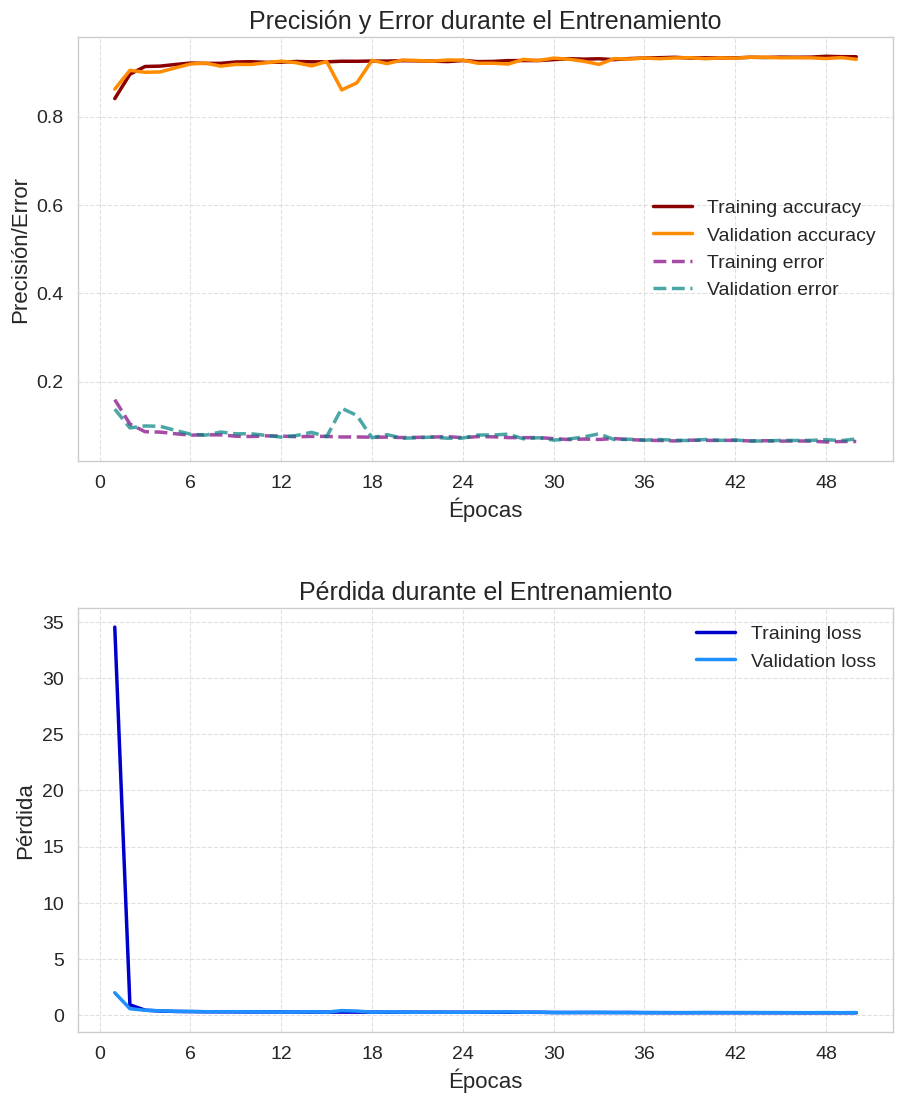

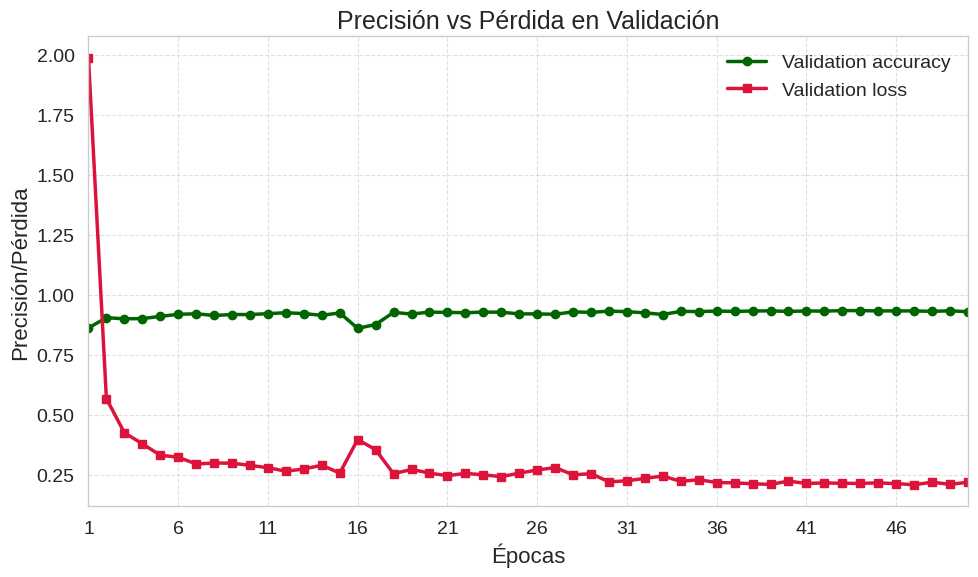

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

# Obtener el historial de entrenamiento
history_dict = history.history
n_epochs = len(history_dict['accuracy'])
epochs = np.arange(1, n_epochs + 1)

# Preparar datos
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_err = 1.0 - np.asarray(train_acc)
val_err = 1.0 - np.asarray(val_acc)

# Configurar estilo profesional
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.figsize': (10, 8),
    'figure.dpi': 100,
    'lines.linewidth': 2.5,
    'grid.alpha': 0.6
})

# Crear figura con 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Gráfico de Precisión
ax1.plot(epochs, train_acc, c='darkred', label='Training accuracy')
ax1.plot(epochs, val_acc, c='darkorange', label='Validation accuracy')
ax1.plot(epochs, train_err, c='purple', linestyle='--', alpha=0.7, label='Training error')
ax1.plot(epochs, val_err, c='teal', linestyle='--', alpha=0.7, label='Validation error')
ax1.set_title('Precisión y Error durante el Entrenamiento', fontsize=18)
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Precisión/Error')
ax1.legend(loc='center right')
ax1.grid(True, ls='--', alpha=0.6)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# Gráfico de Pérdida
ax2.plot(epochs, train_loss, c='mediumblue', label='Training loss')
ax2.plot(epochs, val_loss, c='dodgerblue', label='Validation loss')
ax2.set_title('Pérdida durante el Entrenamiento', fontsize=18)
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Pérdida')
ax2.legend(loc='upper right')
ax2.grid(True, ls='--', alpha=0.6)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

# Ajustar espacio entre subplots
plt.tight_layout(pad=3.0)

# Guardar figura
#plt.savefig('../Results/training_metrics_combined.png', bbox_inches='tight')
plt.show()

# Gráfico adicional: Precisión vs Pérdida en validación
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_acc, c='darkgreen', marker='o', markersize=6, label='Validation accuracy')
plt.plot(epochs, val_loss, c='crimson', marker='s', markersize=6, label='Validation loss')
plt.title('Precisión vs Pérdida en Validación', fontsize=18)
plt.xlabel('Épocas')
plt.ylabel('Precisión/Pérdida')
plt.legend()
plt.grid(True, ls='--', alpha=0.6)
plt.xlim(1, n_epochs)
plt.xticks(np.arange(1, n_epochs+1, max(1, n_epochs//10)))
plt.tight_layout()
#plt.savefig('../Results/validation_accuracy_vs_loss.png', bbox_inches='tight')
plt.show()

## Matriz de Confusión 

156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


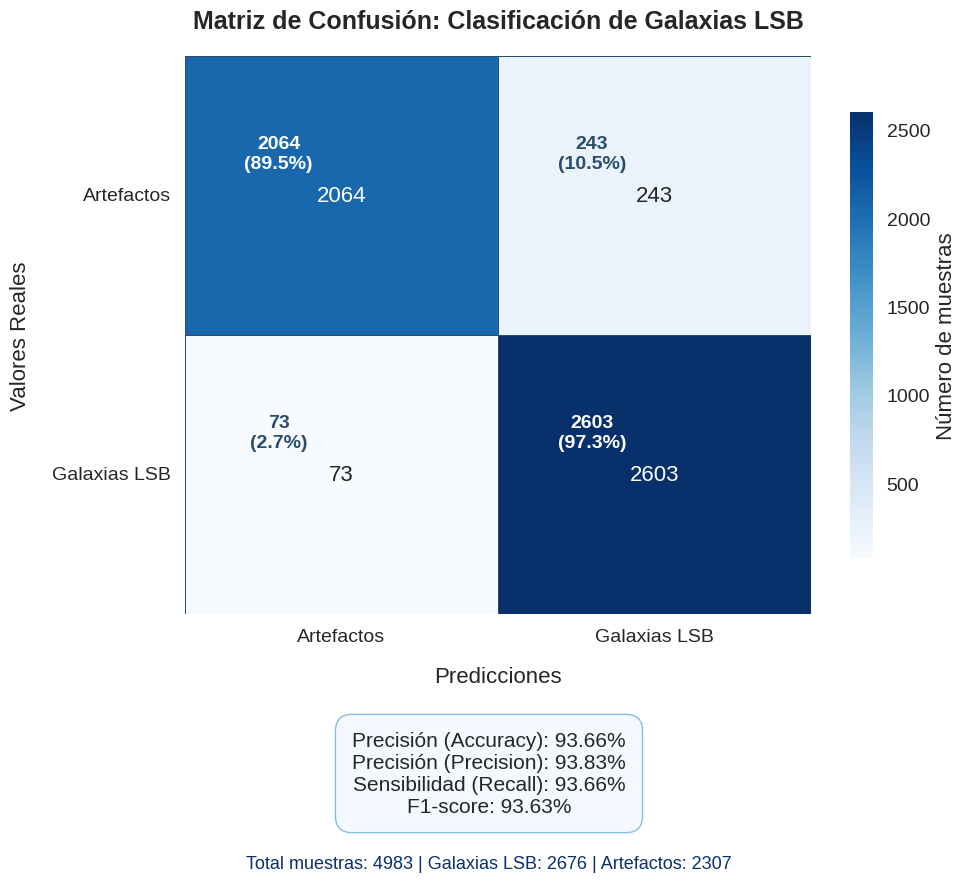

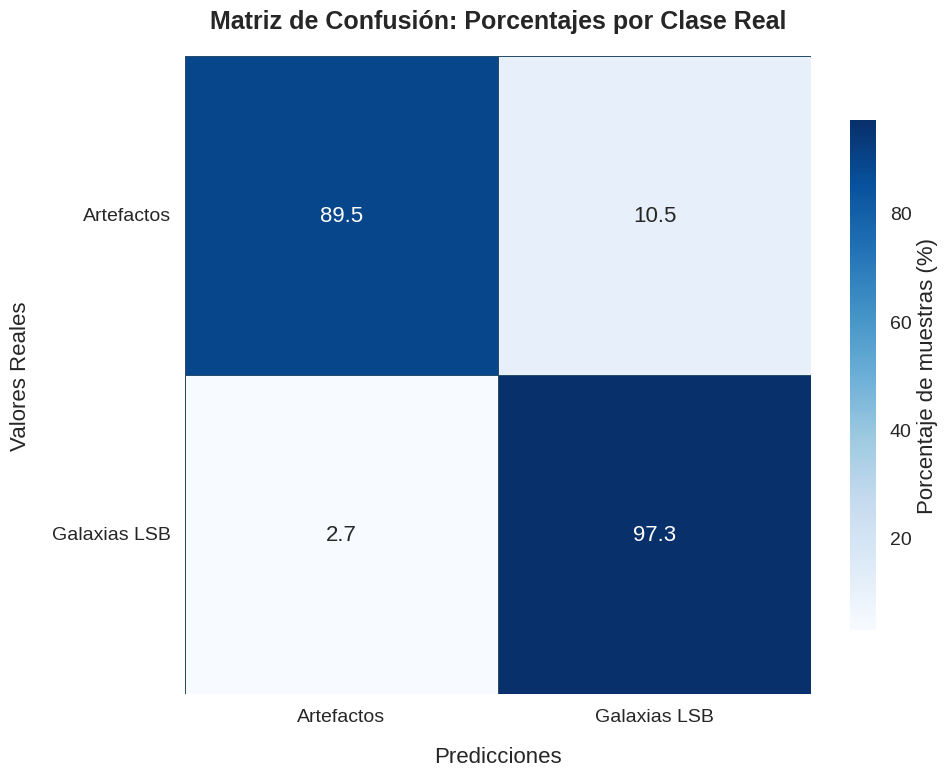

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.colors import LinearSegmentedColormap

# Generar predicciones
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)

# Calcular métricas de clasificación
report = classification_report(y_test, y_pred_classes, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']
accuracy = report['accuracy']

# Configuración estética
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.figsize': (12, 10),
    'figure.dpi': 100
})

# Crear figura
plt.figure(figsize=(10, 8))

# Paleta de colores personalizada
colors = ["#f7fbff", "#deebf7", "#c6dbef", "#9ecae1", "#6baed6", "#4292c6", "#2171b5", "#08519c", "#08306b"]
cmap = LinearSegmentedColormap.from_list("custom_blue", colors, N=256)

# Heatmap de matriz de confusión
ax = sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, 
                 cbar_kws={'shrink': 0.8, 'label': 'Número de muestras'},
                 linewidths=0.5, linecolor='#2a4d69', annot_kws={'size': 16})

# Configurar etiquetas
class_names = ['Artefactos', 'Galaxias LSB']
ax.set_xlabel('Predicciones', fontsize=16, labelpad=15)
ax.set_ylabel('Valores Reales', fontsize=16, labelpad=15)
ax.set_xticklabels(class_names, fontsize=14)
ax.set_yticklabels(class_names, fontsize=14, rotation=0)

# Calcular porcentajes
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100

# Añadir porcentajes internos
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        perc = f"{cm_perc[i, j]:.1f}%"
        ax.text(j+0.3, i+0.35, f"{value}\n({perc})", 
                ha='center', va='center', 
                color='white' if cm[i, j] > thresh else '#2a4d69',
                fontsize=14, fontweight='bold')

# Título con métricas clave
plt.title('Matriz de Confusión: Clasificación de Galaxias LSB', 
          fontsize=18, pad=20, fontweight='bold')

# Añadir caja con métricas generales
metrics_text = (f"Precisión (Accuracy): {accuracy:.2%}\n"
                f"Precisión (Precision): {precision:.2%}\n"
                f"Sensibilidad (Recall): {recall:.2%}\n"
                f"F1-score: {f1:.2%}")

plt.figtext(0.5, -0.08, metrics_text, 
            ha='center', fontsize=15, 
            bbox=dict(facecolor='#f0f8ff', alpha=0.8, 
                      edgecolor='#6baed6', boxstyle='round,pad=0.8'))

# Añadir información adicional
plt.figtext(0.5, -0.15, 
            f"Total muestras: {len(y_test)} | Galaxias LSB: {np.sum(y_test==1)} | Artefactos: {np.sum(y_test==0)}",
            ha='center', fontsize=13, color='#08306b')

# Ajustar diseño
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

# Guardar en alta resolución
plt.savefig('../confusion_matrix.png', bbox_inches='tight', dpi=120)
plt.show()

# Versión alternativa con división por porcentajes
plt.figure(figsize=(10, 8))
sns.heatmap(cm_perc, annot=True, fmt='.1f', cmap=cmap, 
            cbar_kws={'shrink': 0.8, 'label': 'Porcentaje de muestras (%)'},
            linewidths=0.5, linecolor='#2a4d69', annot_kws={'size': 16})

# Configurar etiquetas
plt.xlabel('Predicciones', fontsize=16, labelpad=15)
plt.ylabel('Valores Reales', fontsize=16, labelpad=15)
plt.xticks(ticks=[0.5, 1.5], labels=class_names, fontsize=14)
plt.yticks(ticks=[0.5, 1.5], labels=class_names, fontsize=14, rotation=0)
plt.title('Matriz de Confusión: Porcentajes por Clase Real', 
          fontsize=18, pad=20, fontweight='bold')

plt.tight_layout()
plt.savefig('../confusion_matrix_percentages.png', bbox_inches='tight', dpi=120)
plt.show()